Import modules and prep training data

In [1]:
from Pfeature.pfeature import aac_wp
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
import pandas as pd
import os
import lazypredict
from lazypredict.Supervised import LazyClassifier

# prep positive data and label
aac_wp('/home/jovyan/work/Short_AMPs_Predictor/train_set/po_cd_hit.txt', '/home/jovyan/work/Short_AMPs_Predictor/po_aac.csv')
po_df = pd.read_csv('po_aac.csv')
po_df['y'] = 1
po_df

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y,y
0,27.27,0.00,9.09,0.00,9.09,9.09,0.00,0.00,0.00,0.00,...,9.09,9.09,0.00,0.00,0.00,0.00,18.18,0.00,9.09,1
1,0.00,54.55,0.00,9.09,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,18.18,18.18,0.00,0.00,0.00,1
2,0.00,0.00,9.09,18.18,9.09,9.09,9.09,0.00,0.00,9.09,...,0.00,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00,1
3,0.00,0.00,0.00,18.18,9.09,9.09,9.09,0.00,0.00,9.09,...,9.09,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00,1
4,0.00,0.00,9.09,18.18,18.18,9.09,0.00,0.00,0.00,9.09,...,9.09,18.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,10.00,0.00,3.33,3.33,6.67,20.00,0.00,3.33,13.33,13.33,...,0.00,0.00,3.33,0.00,6.67,3.33,10.00,0.00,0.00,1
1333,6.67,3.33,0.00,0.00,3.33,20.00,6.67,3.33,3.33,6.67,...,6.67,0.00,3.33,6.67,10.00,3.33,13.33,3.33,0.00,1
1334,13.33,0.00,0.00,3.33,0.00,3.33,13.33,0.00,0.00,10.00,...,0.00,16.67,6.67,16.67,6.67,3.33,0.00,0.00,6.67,1
1335,6.67,0.00,6.67,6.67,0.00,6.67,3.33,6.67,6.67,26.67,...,3.33,0.00,10.00,10.00,3.33,3.33,0.00,0.00,0.00,1


In [2]:
# prep negative data and label
aac_wp('train_set/ne_cd_hit.txt', 'ne_aac.csv')
ne_df = pd.read_csv('ne_aac.csv')
ne_df['y'] = 0
ne_df

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y,y
0,0.00,0.00,0.00,0.00,0.00,27.27,0.00,0.00,0.00,9.09,...,9.09,0.00,0.00,18.18,18.18,0.00,9.09,0.00,9.09,0
1,0.00,0.00,0.00,0.00,9.09,27.27,0.00,9.09,0.00,9.09,...,0.00,9.09,0.00,9.09,9.09,18.18,0.00,0.00,0.00,0
2,9.09,0.00,9.09,9.09,9.09,9.09,0.00,9.09,0.00,0.00,...,0.00,27.27,0.00,9.09,9.09,0.00,0.00,0.00,0.00,0
3,9.09,0.00,0.00,0.00,9.09,18.18,0.00,9.09,0.00,18.18,...,0.00,18.18,0.00,9.09,9.09,0.00,0.00,0.00,0.00,0
4,9.09,0.00,9.09,0.00,18.18,0.00,0.00,0.00,9.09,0.00,...,18.18,0.00,0.00,9.09,9.09,9.09,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,13.33,0.00,3.33,3.33,0.00,13.33,0.00,3.33,26.67,10.00,...,3.33,3.33,3.33,0.00,0.00,3.33,0.00,10.00,0.00,0
1418,6.67,0.00,0.00,3.33,6.67,20.00,3.33,3.33,13.33,13.33,...,0.00,3.33,10.00,0.00,6.67,3.33,3.33,0.00,0.00,0
1419,6.67,20.00,0.00,3.33,0.00,10.00,0.00,6.67,10.00,3.33,...,3.33,6.67,0.00,0.00,6.67,6.67,10.00,0.00,6.67,0
1420,6.67,0.00,3.33,3.33,6.67,0.00,3.33,3.33,3.33,6.67,...,16.67,3.33,6.67,10.00,6.67,0.00,13.33,0.00,3.33,0


In [3]:
os.remove('po_aac.csv')
os.remove('ne_aac.csv')

Combine po and ne data and shuffle

In [4]:
X_train = pd.concat([po_df, ne_df], axis=0)
# shuffle data
X_train = X_train.sample(frac=1).reset_index(drop=True)

Seperate X and y data from training

In [5]:
y_train = X_train['y']
X_train.drop(columns='y', inplace=True)
X_train

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,0.00,11.76,0.00,0.00,5.88,11.76,0.00,17.65,5.88,17.65,5.88,0.00,0.00,5.88,5.88,0.00,11.76,0.00,0.00,0.00
1,7.14,0.00,0.00,0.00,7.14,7.14,0.00,14.29,14.29,21.43,7.14,14.29,0.00,0.00,0.00,0.00,7.14,0.00,0.00,0.00
2,3.57,0.00,0.00,0.00,7.14,14.29,7.14,10.71,0.00,14.29,3.57,3.57,3.57,3.57,10.71,3.57,3.57,10.71,0.00,0.00
3,0.00,0.00,11.11,16.67,16.67,0.00,0.00,5.56,5.56,0.00,0.00,0.00,11.11,0.00,5.56,5.56,0.00,5.56,5.56,11.11
4,7.69,0.00,23.08,7.69,0.00,15.38,0.00,0.00,7.69,0.00,0.00,7.69,0.00,0.00,0.00,7.69,7.69,0.00,7.69,7.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,0.00,33.33,0.00,0.00,5.56,11.11,0.00,16.67,0.00,5.56,0.00,0.00,0.00,0.00,16.67,0.00,5.56,5.56,0.00,0.00
2755,0.00,0.00,0.00,0.00,0.00,9.09,0.00,18.18,0.00,27.27,0.00,9.09,18.18,0.00,9.09,0.00,9.09,0.00,0.00,0.00
2756,0.00,14.29,0.00,0.00,0.00,10.71,0.00,10.71,0.00,0.00,7.14,10.71,10.71,7.14,7.14,10.71,3.57,3.57,3.57,0.00
2757,4.76,0.00,0.00,4.76,4.76,14.29,0.00,28.57,14.29,4.76,4.76,0.00,0.00,4.76,0.00,4.76,4.76,4.76,0.00,0.00


In [6]:
y_train

0       0
1       1
2       0
3       0
4       1
       ..
2754    1
2755    1
2756    1
2757    0
2758    1
Name: y, Length: 2759, dtype: int64

In [7]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=matthews_corrcoef)
models_train, predictions_train = clf.fit(X_train, X_train, y_train, y_train)
models_train

100%|██████████| 29/29 [00:07<00:00,  3.95it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
RandomForestClassifier,0.91,0.91,0.91,0.91,0.82,0.99
LabelSpreading,0.91,0.91,0.91,0.91,0.82,0.67
XGBClassifier,0.91,0.91,0.91,0.91,0.82,0.24
LabelPropagation,0.91,0.91,0.91,0.91,0.83,0.60
DecisionTreeClassifier,0.91,0.91,0.91,0.91,0.83,0.08
ExtraTreeClassifier,0.91,0.91,0.91,0.91,0.83,0.02
ExtraTreesClassifier,0.91,0.91,0.91,0.91,0.83,0.37
BaggingClassifier,0.90,0.90,0.90,0.90,0.80,0.21
LGBMClassifier,0.90,0.90,0.90,0.90,0.80,0.32


In [8]:
aac_wp('test_set/po_cd_hit.txt', 'po_cd_hit.csv')
aac_wp('test_set/ne_cd_hit.txt', 'ne_cd_hit.csv')
test_po_df = pd.read_csv('po_cd_hit.csv')
test_ne_df = pd.read_csv('ne_cd_hit.csv')
y_test = [1 for i in range(test_po_df.index.stop)] + [0 for i in range(test_ne_df.index.stop)]
os.remove('po_cd_hit.csv')
os.remove('ne_cd_hit.csv')
X_test = pd.concat([test_po_df, test_ne_df], axis=0)
X_test

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,12.00,0.00,0.00,8.00,0.00,16.00,0.00,0.00,0.00,16.00,0.00,0.00,4.00,8.00,8.00,12.00,12.00,0.00,4.00,0.00
1,6.25,0.00,6.25,0.00,6.25,18.75,0.00,12.50,12.50,12.50,0.00,0.00,0.00,0.00,0.00,6.25,0.00,18.75,0.00,0.00
2,0.00,0.00,4.55,0.00,0.00,13.64,0.00,0.00,9.09,4.55,4.55,4.55,0.00,4.55,31.82,0.00,9.09,4.55,9.09,0.00
3,30.77,0.00,0.00,0.00,7.69,0.00,0.00,0.00,30.77,30.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,17.39,0.00,0.00,0.00,0.00,13.04,0.00,8.70,17.39,21.74,0.00,0.00,0.00,0.00,0.00,0.00,8.70,13.04,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,7.14,0.00,3.57,3.57,10.71,0.00,0.00,0.00,7.14,10.71,0.00,10.71,10.71,7.14,3.57,7.14,3.57,3.57,0.00,10.71
90,7.69,0.00,0.00,0.00,7.69,15.38,0.00,0.00,15.38,7.69,0.00,0.00,0.00,7.69,0.00,7.69,15.38,7.69,0.00,7.69
91,0.00,0.00,0.00,6.67,6.67,6.67,6.67,6.67,13.33,0.00,0.00,6.67,6.67,6.67,0.00,6.67,6.67,20.00,0.00,0.00
92,10.34,0.00,3.45,3.45,3.45,13.79,3.45,13.79,0.00,17.24,3.45,0.00,0.00,0.00,3.45,6.90,3.45,13.79,0.00,0.00


In [9]:
# models_test, predictions_test = clf.fit(X_train, X_test, y_train, y_test)
# models_test

100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
BernoulliNB,0.81,0.81,0.81,0.81,0.62,0.02
AdaBoostClassifier,0.79,0.79,0.79,0.79,0.58,0.40
KNeighborsClassifier,0.78,0.78,0.78,0.78,0.56,0.02
QuadraticDiscriminantAnalysis,0.78,0.78,0.78,0.78,0.55,0.02
LinearDiscriminantAnalysis,0.77,0.77,0.77,0.77,0.54,0.05
CalibratedClassifierCV,0.77,0.77,0.77,0.77,0.54,1.55
RidgeClassifierCV,0.77,0.77,0.77,0.77,0.54,0.07
RidgeClassifier,0.77,0.77,0.77,0.77,0.54,0.02
GaussianNB,0.77,0.77,0.77,0.77,0.55,0.02


Random Forest is the best so setup for that

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

Apply model

In [11]:
# _predict = []

# for i in range(len(X_test)):
#     prediction = rf.predict(X_test.iloc[i:i+1, :])
#     _predict.append(prediction)

y_test_pred = rf.predict(X_test)
y_test_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0])

In [12]:
accuracy_score(y_test, y_test_pred), matthews_corrcoef(y_test, y_test_pred), confusion_matrix(y_test, y_test_pred)

(0.7712765957446809,
 0.5428297143559941,
 array([[74, 20],
        [23, 71]]))

In [13]:
# all thresholds for aac will ussually be way greater than 0.1
threshold = VarianceThreshold(threshold=0.1)
threshold.fit_transform(X_train)
X2 = X_train.loc[:, threshold.get_support()]
X2

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,0.00,11.76,0.00,0.00,5.88,11.76,0.00,17.65,5.88,17.65,5.88,0.00,0.00,5.88,5.88,0.00,11.76,0.00,0.00,0.00
1,7.14,0.00,0.00,0.00,7.14,7.14,0.00,14.29,14.29,21.43,7.14,14.29,0.00,0.00,0.00,0.00,7.14,0.00,0.00,0.00
2,3.57,0.00,0.00,0.00,7.14,14.29,7.14,10.71,0.00,14.29,3.57,3.57,3.57,3.57,10.71,3.57,3.57,10.71,0.00,0.00
3,0.00,0.00,11.11,16.67,16.67,0.00,0.00,5.56,5.56,0.00,0.00,0.00,11.11,0.00,5.56,5.56,0.00,5.56,5.56,11.11
4,7.69,0.00,23.08,7.69,0.00,15.38,0.00,0.00,7.69,0.00,0.00,7.69,0.00,0.00,0.00,7.69,7.69,0.00,7.69,7.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,0.00,33.33,0.00,0.00,5.56,11.11,0.00,16.67,0.00,5.56,0.00,0.00,0.00,0.00,16.67,0.00,5.56,5.56,0.00,0.00
2755,0.00,0.00,0.00,0.00,0.00,9.09,0.00,18.18,0.00,27.27,0.00,9.09,18.18,0.00,9.09,0.00,9.09,0.00,0.00,0.00
2756,0.00,14.29,0.00,0.00,0.00,10.71,0.00,10.71,0.00,0.00,7.14,10.71,10.71,7.14,7.14,10.71,3.57,3.57,3.57,0.00
2757,4.76,0.00,0.00,4.76,4.76,14.29,0.00,28.57,14.29,4.76,4.76,0.00,0.00,4.76,0.00,4.76,4.76,4.76,0.00,0.00


In [14]:
final_df = pd.DataFrame(data={'Features': X2.columns, 'Gini' : rf.feature_importances_})
final_df.sort_values(by='Gini', ascending=False, inplace=True)
final_df.reset_index(drop=True, inplace=True)
final_df

,Features,Gini
0,AAC_K,0.09
1,AAC_D,0.09
2,AAC_E,0.08
3,AAC_L,0.07
4,AAC_R,0.05
5,AAC_G,0.05
6,AAC_I,0.05
7,AAC_A,0.05
8,AAC_Q,0.05
9,AAC_S,0.05


Text(0.5, 0, 'Feature Importance')

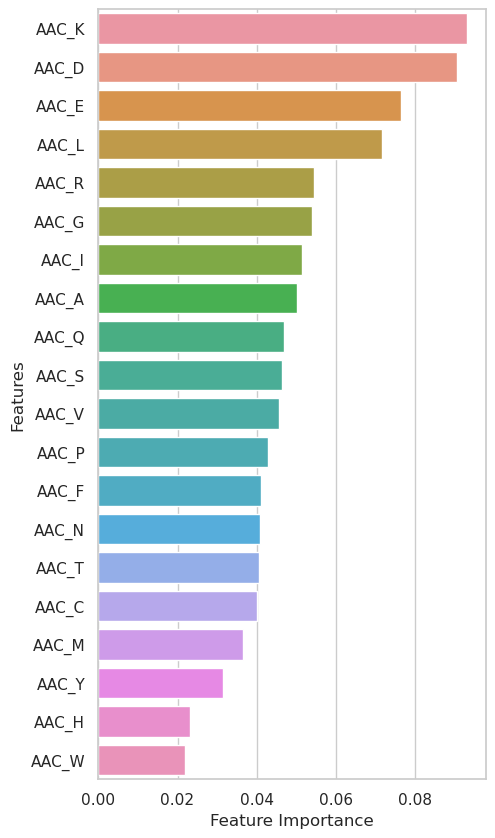

In [15]:
# Combine feature names and Gini values into a Dataframe
# Plot of feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'Gini', y = 'Features', data = final_df)
plt.xlabel("Feature Importance")